In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

#PRİMARY ID'Sİ AYNI OLANLARIN YAN ETKİLERİ BİRLEŞTİRİLDİ.
# Veriyi yükleme
data = pd.read_excel('veriseti_tez.xlsx')

# Her 'primaryid' için birden fazla 'pt' varsa, onları birleştiriyoruz.
grouped_data = data.groupby('primaryid').agg({
    'pt': lambda x: '|'.join(set(x))  # Benzersiz sınıfları birleştir
}).reset_index()

# Her 'primaryid' için ilişkili tüm satırları tutarak orijinal veriyi birleştiriyoruz
expanded_data = data.merge(
    grouped_data, 
    on='primaryid', 
    how='left',
    suffixes=('', '_merged')  # Yeni pt sütununu farklı isimle ekle
)

# Yeni sütunları kontrol etme
print(expanded_data.head(50))

# Sınıf destek değerlerini kontrol etme
expanded_class_frequencies = expanded_data['pt_merged'].value_counts()
print(f"Güncellenmiş sınıf frekansları:\n{expanded_class_frequencies}")


C:\Users\HP\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\HP\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:241: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


    primaryid    caseid  caseversion i_f_code    event_dt    mfr_dt  \
0   236933161  23693316            1        I  20240318.0  20240329   
1   236933941  23693394            1        I  20240309.0  20240329   
2   236933941  23693394            1        I  20240309.0  20240329   
3   236934011  23693401            1        I         NaN  20240330   
4   236934011  23693401            1        I         NaN  20240330   
5   236934011  23693401            1        I         NaN  20240330   
6   236934011  23693401            1        I         NaN  20240330   
7   236934011  23693401            1        I         NaN  20240330   
8   236934011  23693401            1        I         NaN  20240330   
9   236934011  23693401            1        I         NaN  20240330   
10  236934011  23693401            1        I         NaN  20240330   
11  236934011  23693401            1        I         NaN  20240330   
12  236936391  23693639            1        I  20240327.0  20240331   
13  23

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import cohen_kappa_score, log_loss
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping


X = expanded_data[["prod_ai", "drugname", "indi_pt", "primaryid", "caseid", "age", 
          "event_dt", "init_fda_dt", "fda_dt", "mfr_dt", "rept_dt", "wt", 
          "start_dt", "outc_cod", "occp_cod", "drug_seq"]].copy()
y = expanded_data['pt_merged'].copy()

# Veri ön işleme
numeric_cols = X.select_dtypes(include=[np.number]).columns
categorical_cols = X.select_dtypes(exclude=[np.number]).columns

X.loc[:, numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].mean())
for col in categorical_cols:
    X.loc[:, col] = X[col].fillna(X[col].mode()[0])
    X.loc[:, col] = LabelEncoder().fit_transform(X[col])

# encoding ve veri türü dönüşümü
le = LabelEncoder()
y_encoded = le.fit_transform(y).astype('float32')
num_classes = len(np.unique(y_encoded))

# Standardizasyon
scaler = StandardScaler()
X.loc[:, numeric_cols] = scaler.fit_transform(X[numeric_cols])
X = X.astype('float32')

# Veri bölme
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Tensor dönüşümü
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

# Model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Derleme ve eğitim
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_split=0.2, 
                    callbacks=[early_stopping], 
                    verbose=1)
# Model değerlendirme
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)



# Metrikler
print(f"Accuracy: {accuracy_score(y_test, y_pred_classes):.4f}")
print(f"Macro F1: {f1_score(y_test, y_pred_classes, average='macro'):.4f}")
print(f"Weighted F1: {f1_score(y_test, y_pred_classes, average='weighted'):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred_classes):.4f}")
#print(f"Log Loss: {log_loss(y_test_cat, y_pred):.4f}")
print("\nDetaylı Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred_classes))

Epoch 1/50


C:\Users\HP\AppData\Local\Temp\ipykernel_21920\1789647582.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-2.21662163 -2.21333397 -2.21333397 ...  1.23352587  1.23352587
  1.23352587]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, numeric_cols] = scaler.fit_transform(X[numeric_cols])
C:\Users\HP\AppData\Local\Temp\ipykernel_21920\1789647582.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-2.21662163 -2.21333397 -2.21333397 ...  1.23352587  1.23352587
  1.23352587]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, numeric_cols] = scaler.fit_transform(X[numeric_cols])
C:\Users\HP\AppData\Local\Temp\ipykernel_21920\1789647582.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pa

882/882 [==============================] - 4s 3ms/step - loss: 5.2527 - accuracy: 0.3743 - val_loss: 3.7848 - val_accuracy: 0.4191
Epoch 2/50
882/882 [==============================] - 3s 3ms/step - loss: 3.5159 - accuracy: 0.4196 - val_loss: 3.2548 - val_accuracy: 0.4304
Epoch 3/50
882/882 [==============================] - 3s 3ms/step - loss: 3.2768 - accuracy: 0.4255 - val_loss: 3.0409 - val_accuracy: 0.4542
Epoch 4/50
882/882 [==============================] - 3s 3ms/step - loss: 3.0543 - accuracy: 0.4472 - val_loss: 2.8093 - val_accuracy: 0.4908
Epoch 5/50
882/882 [==============================] - 3s 3ms/step - loss: 2.8571 - accuracy: 0.4828 - val_loss: 2.6708 - val_accuracy: 0.5258
Epoch 6/50
882/882 [==============================] - 3s 3ms/step - loss: 2.6929 - accuracy: 0.5071 - val_loss: 2.4166 - val_accuracy: 0.5388
Epoch 7/50
882/882 [==============================] - 3s 3ms/step - loss: 2.4927 - accuracy: 0.5244 - val_loss: 2.2072 - val_accuracy: 0.5425
Epoch 8/50
882/88

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_

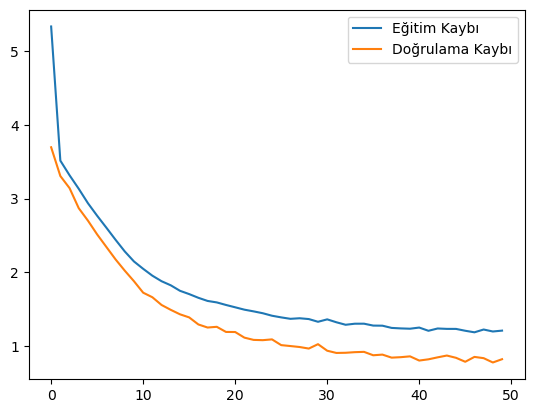

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.legend()
plt.show()



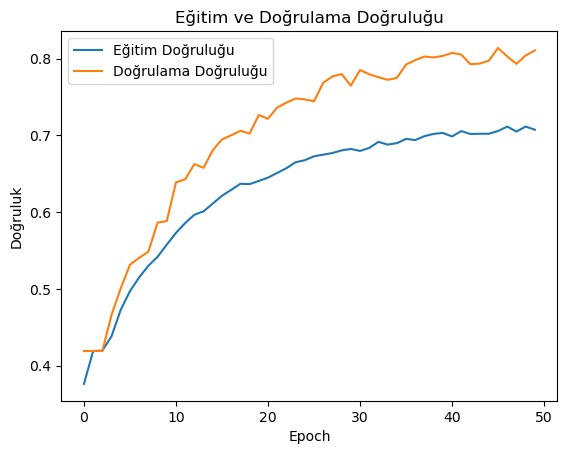

In [26]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğruluğu
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

